# HuggingFaceのモデルをカスタマイズしてBLIP2を日本語化するための実験

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


とりあえず確認はCPU上でやる。

## BLIP2を調べる
https://huggingface.co/docs/transformers/v4.31.0/en/model_doc/blip-2  
上記ページに書いてあるモジュールを一つづつ見ていく。

### Blip2Config

In [5]:
from transformers import (
    Blip2VisionConfig,
    Blip2QFormerConfig,
    OPTConfig,
    Blip2Config,
    Blip2ForConditionalGeneration,
)

In [7]:
# Initializing a Blip2Config with Salesforce/blip2-opt-2.7b style configuration
configuration = Blip2Config()
configuration

Blip2Config {
  "_commit_hash": null,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "model_type": "blip-2",
  "num_query_tokens": 32,
  "qformer_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_frequency": 2,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_hidden_size": 1408,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
   

In [8]:
# Initializing a Blip2ForConditionalGeneration (with random weights) from the Salesforce/blip2-opt-2.7b style configuration
model = Blip2ForConditionalGeneration(configuration)
model

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [10]:
# Accessing the model configuration
model.config == configuration

True

In [12]:
# We can also initialize a Blip2Config from a Blip2VisionConfig, Blip2QFormerConfig and any PretrainedConfig

# Initializing BLIP-2 vision, BLIP-2 Q-Former and language model configurations
vision_config = Blip2VisionConfig()
qformer_config = Blip2QFormerConfig()
text_config = OPTConfig()

composed_config = Blip2Config.from_text_vision_configs(vision_config, qformer_config, text_config)
composed_config

AttributeError: type object 'Blip2Config' has no attribute 'from_text_vision_configs'

公式ページにある例に従っているのにエラーが出た。バージョンの違いか。

### Blip2VisionConfig & Blip2VisionModel

In [24]:
from transformers import Blip2VisionConfig, Blip2VisionModel

# Initializing a Blip2VisionConfig with Salesforce/blip2-opt-2.7b style configuration
configuration = Blip2VisionConfig()
configuration

Blip2VisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu",
  "hidden_size": 1408,
  "image_size": 224,
  "initializer_range": 1e-10,
  "intermediate_size": 6144,
  "layer_norm_eps": 1e-05,
  "model_type": "blip_2_vision_model",
  "num_attention_heads": 16,
  "num_hidden_layers": 39,
  "patch_size": 14,
  "qkv_bias": true,
  "transformers_version": "4.31.0"
}

In [25]:
# Initializing a Blip2VisionModel (with random weights) from the Salesforce/blip2-opt-2.7b style configuration
model = Blip2VisionModel(configuration)
model

Blip2VisionModel(
  (embeddings): Blip2VisionEmbeddings(
    (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
  )
  (encoder): Blip2Encoder(
    (layers): ModuleList(
      (0-38): 39 x Blip2EncoderLayer(
        (self_attn): Blip2Attention(
          (dropout): Dropout(p=0.0, inplace=False)
          (qkv): Linear(in_features=1408, out_features=4224, bias=True)
          (projection): Linear(in_features=1408, out_features=1408, bias=True)
        )
        (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
        (mlp): Blip2MLP(
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
        )
        (layer_norm2): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (post_layernorm): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
)

In [26]:
dummy_input = torch.rand(2, 3, 224, 224)
output = model(pixel_values=dummy_input, output_attentions=True, output_hidden_states=True)
print(type(output))
print(output.keys())

<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])


In [29]:
for k, v in output.items():
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.shape}")
    elif isinstance(v, tuple):
        print(f"{k}: {len(v)}, {v[0].shape}")
    else:
        print(f"{k} is neither torch.Tensor or tuple")

last_hidden_state: torch.Size([2, 257, 1408])
pooler_output: torch.Size([2, 1408])
hidden_states: 40, torch.Size([2, 257, 1408])
attentions: 39, torch.Size([2, 16, 257, 257])


### Blip2QFormerConfig & Blip2QFormerModel

In [30]:
from transformers import Blip2QFormerConfig, Blip2QFormerModel

# Initializing a BLIP-2 Salesforce/blip2-opt-2.7b style configuration
configuration = Blip2QFormerConfig()
configuration

Blip2QFormerConfig {
  "attention_probs_dropout_prob": 0.1,
  "cross_attention_frequency": 2,
  "encoder_hidden_size": 1408,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "blip_2_qformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "vocab_size": 30522
}

In [31]:
# Initializing a model (with random weights) from the Salesforce/blip2-opt-2.7b style configuration
model = Blip2QFormerModel(configuration)
model

Blip2QFormerModel(
  (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): Blip2QFormerEncoder(
    (layer): ModuleList(
      (0): Blip2QFormerLayer(
        (attention): Blip2QFormerAttention(
          (attention): Blip2QFormerMultiHeadAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): Blip2QFormerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (crossattention): Blip2QFormerAttention(
          (attention): Blip2QFormerMultiHeadAttention(
            (query):

In [33]:
query_embeds = torch.rand(2, 10, 768)
encoder_hidden_states = torch.rand(2, 10, 1408)
output = model(query_embeds=query_embeds, encoder_hidden_states=encoder_hidden_states)
print(type(output))
print(output.keys())

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
odict_keys(['last_hidden_state', 'pooler_output'])


Decoderとして使われる場合（上記configだとそうなっているようだ）は引数にencoder_hidden_statesも与える必要がある。

その場合、encoder_attention_maskでマスクを制御できる。実際に使う時にはマスクを入力する必要がありそう。

### Blip2Processor & Blip2Model

In [34]:
from transformers import Blip2Processor, Blip2Model

In [46]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b") # , torch_dtype=torch.float16)  # CPUではfp16は使えない

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

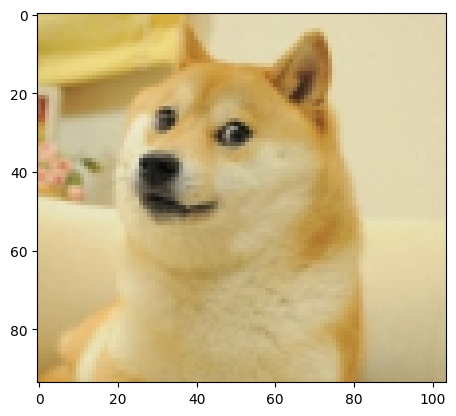

In [47]:
# サンプル画像
img = Image.open("/media/sj-archimedes/data/01_internal/sample_images/dog.png").convert("RGB")
plt.imshow(img)
plt.show()

In [48]:
prompt = "Question: What is this? Answer:"
inputs = processor(images=img, text=prompt, return_tensors="pt")
print(type(inputs))
print(inputs.keys())

<class 'transformers.image_processing_utils.BatchFeature'>
dict_keys(['pixel_values', 'input_ids', 'attention_mask'])


In [49]:
for k, v in inputs.items():
    print(f"{k}: {v.shape}")

pixel_values: torch.Size([1, 3, 224, 224])
input_ids: torch.Size([1, 9])
attention_mask: torch.Size([1, 9])


In [50]:
inputs["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [51]:
outputs = model(**inputs)
print(type(outputs))
print(outputs.keys())

<class 'transformers.models.blip_2.modeling_blip_2.Blip2ForConditionalGenerationModelOutput'>
odict_keys(['logits', 'vision_outputs', 'qformer_outputs', 'language_model_outputs'])


In [59]:
for k, v in outputs.items():
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.shape}")
    elif isinstance(v, tuple) or isinstance(v, list):
        print(f"{k}: {len(v)}, {v[0].shape}")
    else:
        try:
            print(f"{k}:")
            for k1, v1 in v.items():
                if isinstance(v1, torch.Tensor):
                    print(f"\t {k1}: {v1.shape}")
                elif isinstance(v1, tuple) or isinstance(v1, list):
                    print(f"\t {k1}: {len(v1)}, {v1[0].shape}")
                else:
                    print(f"\t {k1} is neither torch.Tensor or tuple or list")
        except:
            pass

logits: torch.Size([1, 41, 50272])
vision_outputs:
	 last_hidden_state: torch.Size([1, 257, 1408])
	 pooler_output: torch.Size([1, 1408])
qformer_outputs:
	 last_hidden_state: torch.Size([1, 32, 768])
	 pooler_output: torch.Size([1, 768])
language_model_outputs:
	 logits: torch.Size([1, 41, 50272])


In [60]:
outputs['language_model_outputs']["past_key_values"]

((tensor([[[[ 3.6384, -2.2171,  2.3665,  ...,  0.3919,  2.5730, -1.3574],
            [-0.2192, -0.5617,  0.5809,  ...,  0.3650,  2.0433,  0.4822],
            [ 2.0654, -1.0977,  0.4667,  ..., -0.7940,  0.6621, -0.2897],
            ...,
            [ 0.5042, -1.4127, -0.8249,  ...,  0.1768,  0.6507,  0.1696],
            [ 0.0583, -1.0454,  0.5341,  ...,  0.7640,  1.5882,  0.0898],
            [ 0.7936,  0.0236, -1.2220,  ..., -0.8803,  1.0021,  0.0967]],
  
           [[-0.0088, -0.0614,  0.7905,  ..., -0.0478,  0.1769, -1.0768],
            [-0.2472, -0.7213,  0.6971,  ..., -0.2380, -0.1628, -0.7886],
            [-0.9096, -0.6252, -0.1752,  ..., -0.1579,  0.4513, -1.4626],
            ...,
            [ 0.4343, -0.9525,  0.0125,  ...,  0.4213,  1.0997, -1.3275],
            [-0.4904, -0.2596,  0.5153,  ...,  0.2241, -0.6636, -0.8073],
            [ 0.5148, -1.0226,  0.6174,  ...,  0.6096,  0.8590,  0.4776]],
  
           [[ 0.3538,  0.2128,  1.0844,  ...,  0.2047,  0.5426, -0.665

In [63]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Salesforce/blip2-opt-2.7b")
inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs)
print(text_features.keys())

odict_keys(['logits', 'past_key_values'])


In [64]:
text_features["logits"].shape

torch.Size([2, 6, 50272])

In [65]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [67]:
prompt = "Question: What is this? Answer:"
inputs1 = processor(images=img, text=prompt, return_tensors="pt")
inputs2 = tokenizer([prompt], padding=True, return_tensors="pt")
print((inputs1["input_ids"] == inputs2["input_ids"]).all())

tensor(True)


Blip2Processorのテキスト処理部分はAutoTokenizerから作ったトークナイザーと同じ

In [70]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
inputs3 = processor(images=img, return_tensors="pt")
image_outputs = model.get_image_features(**inputs3)
print(image_outputs.keys())

odict_keys(['last_hidden_state', 'pooler_output'])


In [71]:
image_outputs["last_hidden_state"].shape

torch.Size([1, 257, 1408])

In [72]:
print((inputs1["pixel_values"] == inputs3["pixel_values"]).all())

tensor(True)


Blip2Processorの画像処理部分はAutoProcessorから作った前処理関数と同じ

In [76]:
inputs = processor(images=img, return_tensors="pt")
print(inputs.keys())
qformer_outputs = model.get_qformer_features(**inputs)
print(qformer_outputs.keys())

dict_keys(['pixel_values'])
odict_keys(['last_hidden_state', 'pooler_output'])


In [77]:
qformer_outputs = model.get_qformer_features(**inputs3)
print((inputs["pixel_values"] == inputs3["pixel_values"]).all())

tensor(True)


画像特徴量を入力してQ-formerの出力を得ることができる。

画像特徴量はBlip2Processorに画像だけを入力して計算しても良い。

### Blip2ForConditionalGeneration
BLIP-2 Model for generating text given an image and an optional text prompt. The model consists of a vision encoder, Querying Transformer (Q-Former) and a language model.

One can optionally pass input_ids to the model, which serve as a text prompt, to make the language model continue the prompt. Otherwise, the language model starts generating text from the [BOS] (beginning-of-sequence) token.

In [78]:
from transformers import Blip2ForConditionalGeneration

In [79]:
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

inputs = processor(images=img, return_tensors="pt")
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/naoto_tanji/.pyenv/versions/3.11.1/envs/llama2/lib/python3.11/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a doge sitting on a couch with a caption that says "i am a doge"


dogではなくdogeを知っている。

In [80]:
# テキストも入力する場合

prompt = "This is"
inputs = processor(images=img, text=prompt, return_tensors="pt")
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

the best meme of the year


In [82]:
prompt = "Question: What is this? Answer: "
inputs = processor(images=img, text=prompt, return_tensors="pt")
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

_____


残りタスク
- Blip2ModelをAutoregressiveタスクを学習させる方法の理解
- 学習させた重みをBlip2ForConditionalGenerationに読み込ませて使う方法、またはBlip2Modelをそのまま使って文章生成させる方法の理解